In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Lambda
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
sns.set()

In [198]:
df = pd.read_csv('sentiment-emotion-labelled_Dell_tweets.csv')
df.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124


In [199]:
df.shape

(24970, 9)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24970 entries, 0 to 24969
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       24970 non-null  int64  
 1   Datetime         24970 non-null  object 
 2   Tweet Id         24970 non-null  int64  
 3   Text             24970 non-null  object 
 4   Username         24970 non-null  object 
 5   sentiment        24970 non-null  object 
 6   sentiment_score  24970 non-null  float64
 7   emotion          24970 non-null  object 
 8   emotion_score    24970 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 1.7+ MB


In [201]:
df.apply(pd.isnull).sum()

Unnamed: 0         0
Datetime           0
Tweet Id           0
Text               0
Username           0
sentiment          0
sentiment_score    0
emotion            0
emotion_score      0
dtype: int64

In [202]:
df['emotion'].value_counts()

emotion
anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: count, dtype: int64

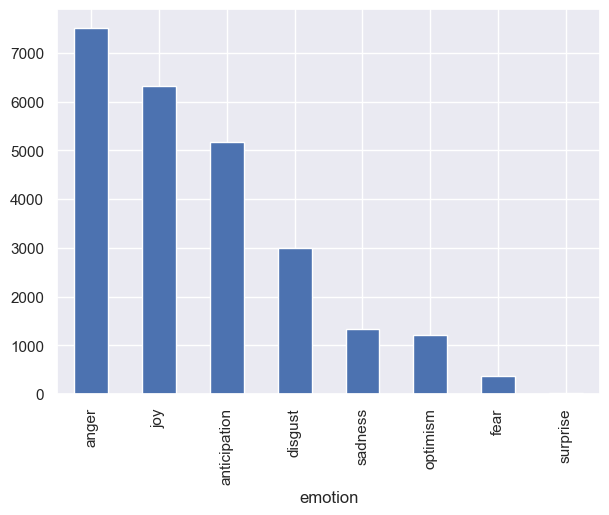

In [203]:
df['emotion'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

In [204]:
df['sentiment'].value_counts()

sentiment
negative    10556
positive     7366
neutral      7048
Name: count, dtype: int64

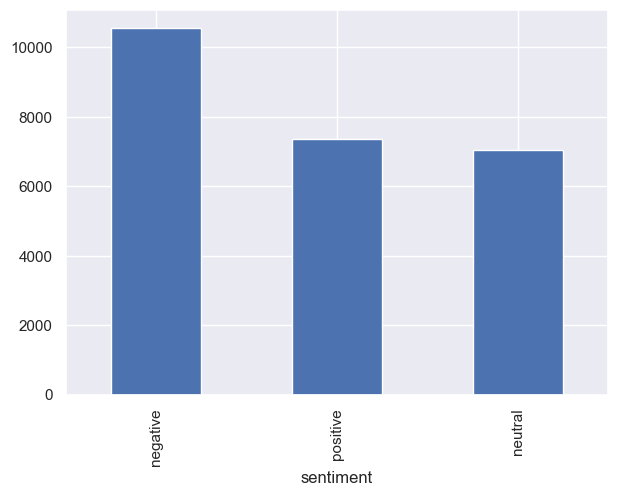

In [205]:
df['sentiment'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

In [206]:
df_neutral = df[df['sentiment'] == 'neutral']
df_positive = df[df['sentiment'] == 'positive'].sample(df_neutral.shape[0])
df_negative = df[df['sentiment'] == 'negative'].sample(df_neutral.shape[0])

In [207]:
df_balanced = pd.concat([df_neutral, df_positive, df_negative])

In [208]:
df_balanced.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124
6,6,2022-09-30 19:31:57+00:00,1575931475391746048,@emijuju_ @Alienware @Dell @IntelGaming alien ...,diegoaygo,neutral,0.733473,fear,0.370504
9,9,2022-09-30 19:02:37+00:00,1575924090187153416,What's your biggest data management challenge?...,InfoSystems,neutral,0.718806,optimism,0.894296


In [209]:
df_balanced.shape

(21144, 9)

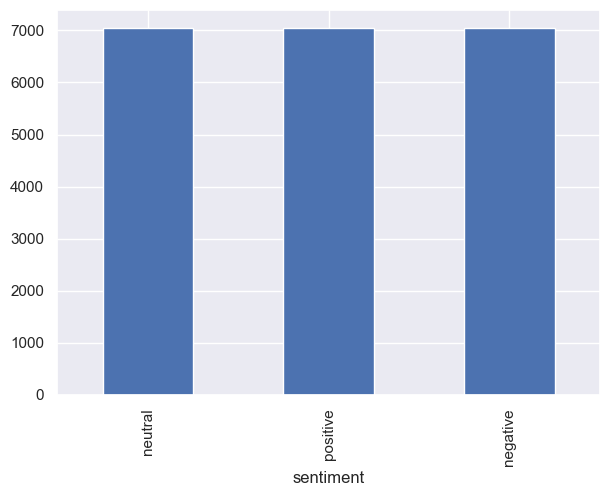

In [210]:
df_balanced['sentiment'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

In [211]:
df_balanced = df_balanced[['Text', 'sentiment']]
df_balanced.head()

,Text,sentiment
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral
1,@MK_habit_addict @official_stier @MortalKombat...,neutral
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral
6,@emijuju_ @Alienware @Dell @IntelGaming alien ...,neutral
9,What's your biggest data management challenge?...,neutral


In [212]:
df_balanced['Text'][0]

'@Logitech @apple @Google @Microsoft @Dell @Lenovo #WhatIf QWERTY were modified for programmers so things like brackets, parens, quotes, operators, etc. moved to the middle near G-H splitting left/right brackets to separate hands, and relieving the less dextrous pinky finger?'

In [213]:
df_balanced['Text'][1]

"@MK_habit_addict @official_stier @MortalKombat @newzealand She's getting a new @Dell #laptop when the one she has one only 2-3 years old.  (More than triple the price - though much higher utility). https://t.co/7WvkCw7vQf"

In [214]:
sw = stopwords.words('english')

In [215]:
lemmatizer = WordNetLemmatizer()

In [216]:
def text_cleaning(text):
    text = text.lower()
    text = re.sub('@\w+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [217]:
df_balanced['cleaned_text'] = df_balanced['Text'].apply(text_cleaning)

In [218]:
df_balanced.head()

,Text,sentiment,cleaned_text
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral,whatif qwerty modified programmer thing like b...
1,@MK_habit_addict @official_stier @MortalKombat...,neutral,getting new laptop one one year old triple pri...
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral,give man paid
6,@emijuju_ @Alienware @Dell @IntelGaming alien ...,neutral,alien shaped omurice
9,What's your biggest data management challenge?...,neutral,biggest data management challenge cloud comple...


In [219]:
df_balanced['Text'][0]

'@Logitech @apple @Google @Microsoft @Dell @Lenovo #WhatIf QWERTY were modified for programmers so things like brackets, parens, quotes, operators, etc. moved to the middle near G-H splitting left/right brackets to separate hands, and relieving the less dextrous pinky finger?'

In [220]:
df_balanced['cleaned_text'][0]

'whatif qwerty modified programmer thing like bracket parens quote operator etc moved middle near h splitting left right bracket separate hand relieving less dextrous pinky finger'

In [221]:
df_balanced['Text'][1]

"@MK_habit_addict @official_stier @MortalKombat @newzealand She's getting a new @Dell #laptop when the one she has one only 2-3 years old.  (More than triple the price - though much higher utility). https://t.co/7WvkCw7vQf"

In [222]:
df_balanced['cleaned_text'][1]

'getting new laptop one one year old triple price though much higher utility'

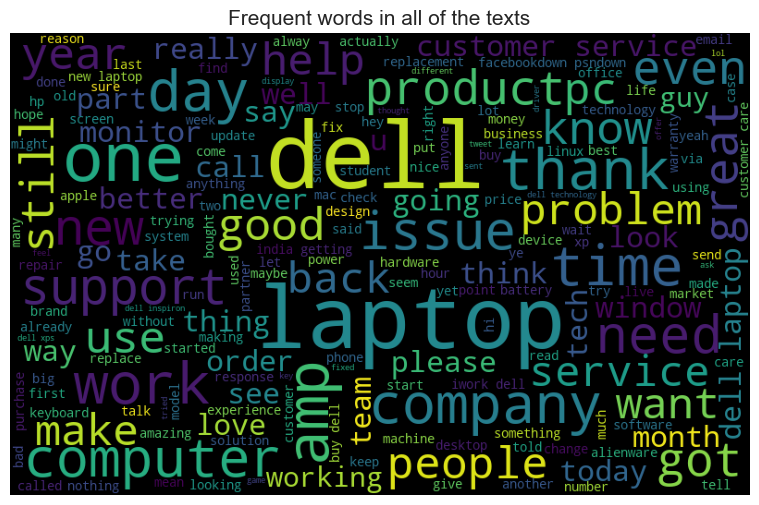

In [223]:
plt.figure(figsize = (11, 6))
all_sent = ' '.join([sentence for sentence in df_balanced['cleaned_text']])
wordcloud_all = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sent)
plt.imshow(wordcloud_all)
plt.title('Frequent words in all of the texts', fontsize = 15)
plt.axis('off')
plt.show()

In [224]:
def word_cloud(sentiment):
    plt.figure(figsize = (11, 6))
    all_sent = ' '.join([sentence for sentence in df_balanced['cleaned_text'][df_balanced['sentiment'] == sentiment]])
    word_cloud_sen = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sent)
    plt.imshow(word_cloud_sen)
    plt.title(sentiment)
    plt.axis('off')
    plt.show()

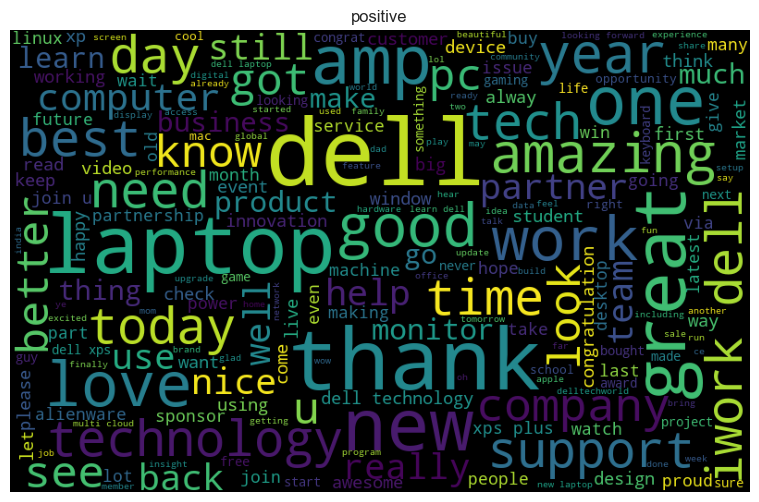

In [225]:
word_cloud('positive')

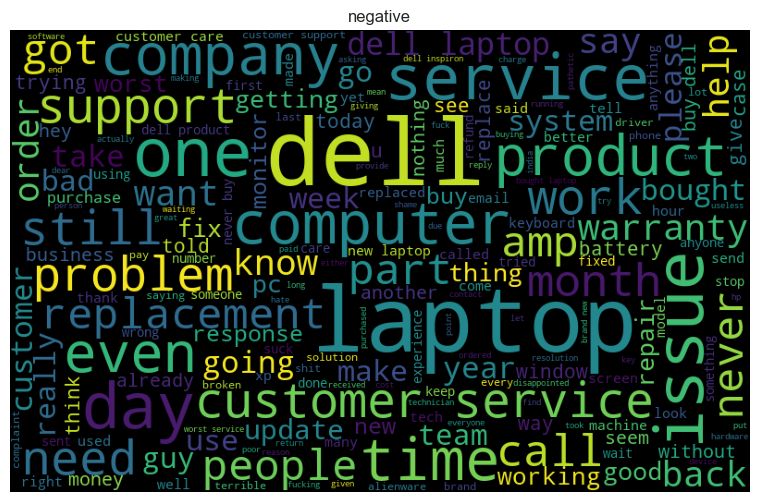

In [226]:
word_cloud('negative')

In [227]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_balanced['cleaned_text'])
seq = tokenizer.texts_to_sequences(df_balanced['cleaned_text'])

In [228]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20167

In [229]:
maxlen = max([len(i) for i in seq])
maxlen

70

In [230]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [231]:
le = LabelEncoder()

In [232]:
y = le.fit_transform(df_balanced['sentiment'])

In [233]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.2, random_state = 101, stratify = y, shuffle = True)

In [234]:
embedding_matrix = dict()
glove_file = open('glove.6B.100d.txt', encoding = 'utf8')
for line in glove_file:
    record = line.split()
    word = record[0]
    vec = np.asarray(record[1: ], dtype = 'float32')
    embedding_matrix[word] = vec
glove_file.close()

In [235]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embedding_matrix.get(word)
    if vector is not None:
        embedding_vectors[index] = vector

In [236]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.023187  , -0.27660999, -0.0084629 , ..., -0.61162001,
         1.20009995,  0.35113999],
       [-0.12612   ,  0.15564001,  0.73378003, ..., -0.35663   ,
         1.30400002, -0.4711    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.46362999,  0.15649   ,  0.72188002, ...,  0.32010001,
        -0.14827   ,  0.41602001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [314]:
model = Sequential()

In [315]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))

In [316]:
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [317]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [318]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.4735 - loss: 1.0159 - val_accuracy: 0.6619 - val_loss: 0.7737
Epoch 2/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.6613 - loss: 0.7632 - val_accuracy: 0.6868 - val_loss: 0.7187
Epoch 3/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.6919 - loss: 0.7127 - val_accuracy: 0.6915 - val_loss: 0.6983
Epoch 4/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.7074 - loss: 0.6797 - val_accuracy: 0.7039 - val_loss: 0.6819
Epoch 5/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.7198 - loss: 0.6627 - val_accuracy: 0.7086 - val_loss: 0.6679
Epoch 6/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.7276 - loss: 0.6365 - val_accuracy: 0.7163 - val_loss: 0.6635
Epoch 7/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.7326 - loss: 0.6262 - val_accuracy: 0.7222 - val_loss: 0.6488
Epoch 8/100
476/476 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.7340 - loss: 0

In [319]:
model.evaluate(X_test, y_test)

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7580 - loss: 0.5935


[0.6024808883666992, 0.754551887512207]

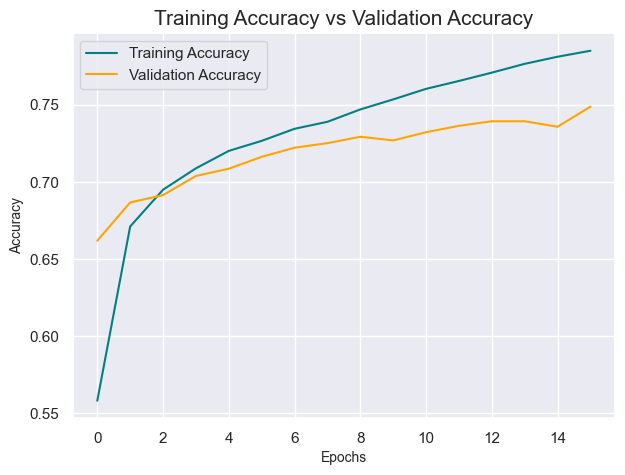

In [320]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

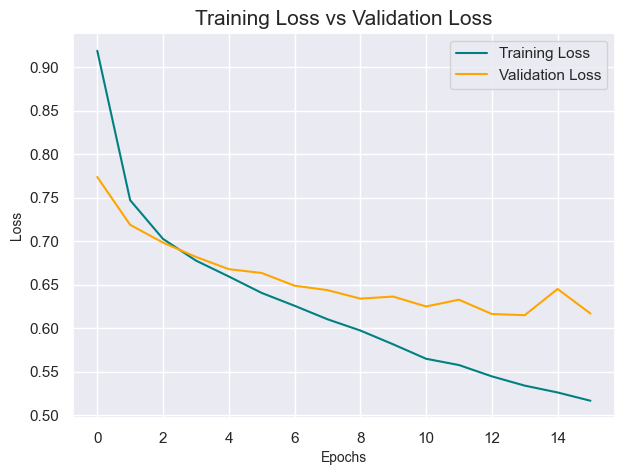

In [322]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [329]:
y_p = model.predict(X_test)

133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


In [330]:
y_pred = [np.argmax(i) for i in y_p]

In [331]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1410
           1       0.67      0.71      0.69      1410
           2       0.80      0.74      0.77      1409

    accuracy                           0.75      4229
   macro avg       0.76      0.75      0.76      4229
weighted avg       0.76      0.75      0.76      4229



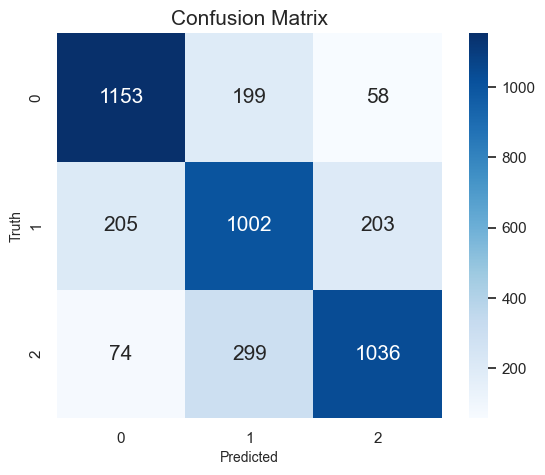

In [333]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = True, annot_kws = {'size': 15}, fmt = 'd',
            cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()